# Modeling Part 1 (fixing bad pull requests)

In [246]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
import nltk
import praw

from nltk.corpus import stopwords
pd.options.display.max_colwidth = 300



# Initialization

In [220]:
df = pd.read_csv('../data/reddit_dominion.csv')
y = df['commments_greater']
X = df['title'] # just used title initially to notice error in data collection later

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [221]:
df.head()

,title,id,created_utc,year,month,full_link,body_len,word_count,char_count,has_media,num_comments,commments_greater
0,"Dominion Deck Builder | Share, discuss and rate Dominion card combinations",en9hw,1292565223,2010,12,https://www.reddit.com/r/dominion/comments/en9hw/dominion_deck_builder_share_discuss_and_rate/,0,11,74,0,0,0
1,Dominion: Cornucopia announced. Theme: Variety.,f2gt5,1295040872,2011,1,https://www.reddit.com/r/dominion/comments/f2gt5/dominion_cornucopia_announced_theme_variety/,0,5,47,0,1,0
2,Online Dominion,fe1r5,1296680348,2011,2,https://www.reddit.com/r/dominion/comments/fe1r5/online_dominion/,0,2,15,0,3,0
3,Looking for someone to play a multiple rounds,fj3la,1297381276,2011,2,https://www.reddit.com/r/dominion/comments/fj3la/looking_for_someone_to_play_a_multiple_rounds/,274,8,45,0,6,0
4,The Secret History of the Dominion Cards (written by Donald X himself!),fw55j,1299108955,2011,3,https://www.reddit.com/r/dominion/comments/fw55j/the_secret_history_of_the_dominion_cards_written/,0,12,71,0,0,0


# Baseline model

In [222]:
y.value_counts(normalize=True)

0    0.518607
1    0.481393
Name: commments_greater, dtype: float64

### If the model predicted majority class (less than or equal to 1 comment), the model would be right 52% of the time. The goal is to improve upon this baseline accuracy.

## Definte lemmatization and stemming functions

In [223]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(doc)
    return [wnl.lemmatize(t) for t in tokens]

def stemmer_tokenizer(doc):
    ps = PorterStemmer()
    tokens = word_tokenize(doc)
    tokens = [ps.stem(re.sub(r"[^a-zA-Z0-9 ]", "", t)) for t in tokens if t not in stops and t not in string.punctuation] #other languages
    tokens = [re.sub(r'\W+', ' ', t) for t in tokens if t not in stops and t not in string.punctuation] #strange characters
    tokens = [re.sub('\d+', '', t) for t in tokens if t not in stops and t not in string.punctuation ] #numerical
    return [ps.stem(re.sub("\\W",'',t)) for t in tokens if t not in stops and t not in string.punctuation]
stops = set(stopwords.words('english'))

# Logistic Regression

### Count Vectorizer

In [224]:
pipe = Pipeline([    
    ('cv', CountVectorizer(tokenizer = stemmer_tokenizer, min_df=2)),
    ('lr', LogisticRegression(max_iter=1000)),
])

params = {
    # 'cv__stop_words' : [None, 'english'],
    'cv__ngram_range' : [(1,1),(1,2)],
    'lr__C': [1,2,3]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)
gs.fit(X_train, y_train)
print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params:  {'cv__ngram_range': (1, 2), 'lr__C': 1}
Best Estimator Score Train:  0.8425093632958801
Best Estimator Score Test:  0.5732734418865806


In [225]:
predictions = gs.predict(X_test)

incorrect_df = pd.DataFrame(X_test)
incorrect_df['target'] = y
incorrect_df['predictions'] = predictions
incorrect_df['correct_logistic'] = incorrect_df['predictions'] == incorrect_df['target']
incorrect_df = incorrect_df[incorrect_df['correct_logistic']==False]
incorrect_df.drop(columns = ['correct_logistic'], inplace=True)

incorrect_df['link'] = df.iloc[incorrect_df.index]['full_link']
incorrect_df['n_comments'] = df.iloc[incorrect_df.index]['num_comments']

# Incorrect number of comments when 0 (checking with actual links)

In [226]:
incorrect_df.head()

,title,target,predictions,link,n_comments
6730,Question: Do the update packs come with Second Edition rulebooks? Or do you need to buy the full Second Edition in order to get the Second Edition rulebook?,0,1,https://www.reddit.com/r/dominion/comments/v901nr/question_do_the_update_packs_come_with_second/,0
1910,Diplomat missing from german Dominion Intrigue?,0,1,https://www.reddit.com/r/dominion/comments/5tgvv6/diplomat_missing_from_german_dominion_intrigue/,3
3460,Rating System,1,0,https://www.reddit.com/r/dominion/comments/dze2nz/rating_system/,8
6484,Do you chapel or not chapel on this board (Base set)?,0,1,https://www.reddit.com/r/dominion/comments/uaklge/do_you_chapel_or_not_chapel_on_this_board_base_set/,0
4742,Nerfing Minion,1,0,https://www.reddit.com/r/dominion/comments/k2oa3l/nerfing_minion/,9


In [227]:
df.iloc[incorrect_df[incorrect_df['n_comments']==0].index]['full_link'].head(10)

6730         https://www.reddit.com/r/dominion/comments/v901nr/question_do_the_update_packs_come_with_second/
6484    https://www.reddit.com/r/dominion/comments/uaklge/do_you_chapel_or_not_chapel_on_this_board_base_set/
5849                         https://www.reddit.com/r/dominion/comments/rusmrc/organizing_cards_into_new_box/
547                                https://www.reddit.com/r/dominion/comments/2mykvg/throne_room_kings_court/
6292      https://www.reddit.com/r/dominion/comments/tk74xc/hi_im_new_here_what_cards_do_you_have_banned_and/
6288      https://www.reddit.com/r/dominion/comments/tjuw7w/two_more_fan_cards_where_i_came_up_with_the_name/
811                   https://www.reddit.com/r/dominion/comments/3bfdma/postchampionship_party_starting_soon/
4212                            https://www.reddit.com/r/dominion/comments/ho99f3/upgraded_adventures_tokens/
4606                                       https://www.reddit.com/r/dominion/comments/jhnlse/fan_card_roamer/
7068      

In [228]:
# Examining post #911
ind = 6484
df.iloc[ind]

title                                                                Do you chapel or not chapel on this board (Base set)?
id                                                                                                                  uaklge
created_utc                                                                                                     1650766720
year                                                                                                                  2022
month                                                                                                                    4
full_link            https://www.reddit.com/r/dominion/comments/uaklge/do_you_chapel_or_not_chapel_on_this_board_base_set/
body_len                                                                                                               404
word_count                                                                                                              11
char_count      

<div>
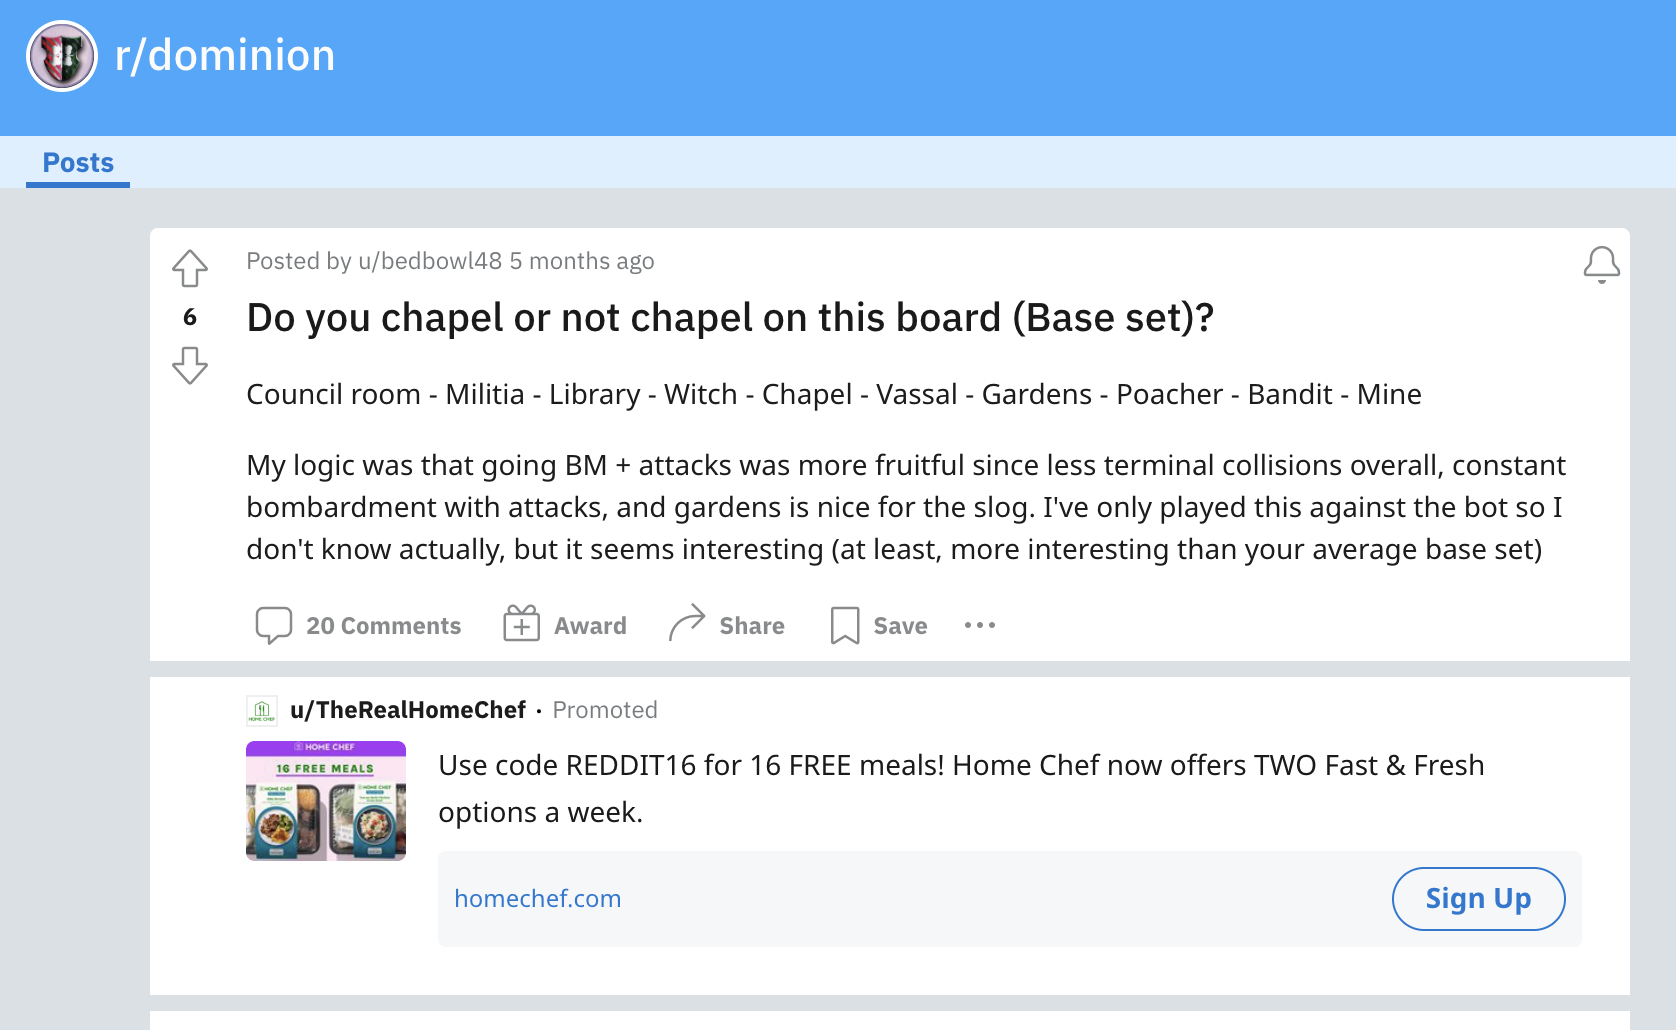
</div>

Note that posts with supposedly 0 comments do not always have 0 comments.


Post #6484 has 20 comments, but PMAW incorrectly listed as 0.

In [229]:
df['num_comments'].value_counts()

0      1643
5       339
7       320
6       319
4       315
       ... 
88        1
71        1
110       1
59        1
104       1
Name: num_comments, Length: 103, dtype: int64

In [206]:
client_id = "Prpl4hKLVGRqXktbEweVfw"
client_secret = "BNQUA54ifRSKOUincvN1AG32AZeR6g"
username = "afalc07"
password = ""
user_agent = "ml_scraper"
  
# creating an authorized reddit instance
reddit = praw.Reddit(client_id = client_id, 
                     client_secret = client_secret, 
                     username = username, 
                     password = password,
                     user_agent = user_agent) 
  

In [230]:
# Real number of columns on row 911 is 42, verifying in code
# data frame incorrectly has 0
comment_id = df.iloc[ind]['id']

# instantiating the Comment class
comment = reddit.submission(comment_id)

# fetching the link_id attribute
num_com = comment.num_comments 
num_com, df.iloc[ind]['num_comments']

(20, 0)

## Finding all posts with supposedly 0 posts and double checking them

### This takes a while to run and has been commented out to not rerun it.

In [152]:
# incorrect_values = 0
# fixed_dict = {}
# for i in range(df.shape[0]):
#     if df.iloc[i]['num_comments']==0:
#         # the ID of the comment
#         comment_id = df.iloc[i]['id']

#         # instantiating the Comment class
#         comment = reddit.submission(comment_id)

#         # fetching the link_id attribute
#         num_com = comment.num_comments 
#         if num_com != df.iloc[i]['num_comments']:
#             incorrect_values+=1
#             fixed_dict[i] = num_com
# incorrect_values

In [209]:
len(fixed_dict)

1075

# FIXING INCORRECT VALUES

In [234]:
for key, val in fixed_dict.items():
    df.at[key, 'num_comments'] = val

In [236]:
df.iloc[ind]['num_comments']

20

In [237]:
## Fixing target column
med = df['num_comments'].median()
df['commments_greater'] = df['num_comments'].apply(lambda val: 1 if val > med else 0)

In [239]:
df.to_csv('../data/reddit_dominion_fixed.csv', index=False)
df.head()

,title,id,created_utc,year,month,full_link,body_len,word_count,char_count,has_media,num_comments,commments_greater
0,"Dominion Deck Builder | Share, discuss and rate Dominion card combinations",en9hw,1292565223,2010,12,https://www.reddit.com/r/dominion/comments/en9hw/dominion_deck_builder_share_discuss_and_rate/,0,11,74,0,0,0
1,Dominion: Cornucopia announced. Theme: Variety.,f2gt5,1295040872,2011,1,https://www.reddit.com/r/dominion/comments/f2gt5/dominion_cornucopia_announced_theme_variety/,0,5,47,0,1,0
2,Online Dominion,fe1r5,1296680348,2011,2,https://www.reddit.com/r/dominion/comments/fe1r5/online_dominion/,0,2,15,0,3,0
3,Looking for someone to play a multiple rounds,fj3la,1297381276,2011,2,https://www.reddit.com/r/dominion/comments/fj3la/looking_for_someone_to_play_a_multiple_rounds/,274,8,45,0,6,0
4,The Secret History of the Dominion Cards (written by Donald X himself!),fw55j,1299108955,2011,3,https://www.reddit.com/r/dominion/comments/fw55j/the_secret_history_of_the_dominion_cards_written/,0,12,71,0,0,0


In [240]:
df['num_comments'].value_counts() 
# Note that 

0      568
5      390
7      380
6      373
4      363
      ... 
96       1
110      1
117      1
80       1
76       1
Name: num_comments, Length: 105, dtype: int64

#### Note that originally 1643 posts with 0 comments has now changed to 568

In [242]:
1643-568

1075

#### A total of 1075 posts were fixed as shown above.